# Codestral with code interpreting and analyzing dataset

This AI assistant is powered by the open-source [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs). The SDK quickly creates a secure cloud sandbox powered by [Firecracker](https://github.com/firecracker-microvm/firecracker). Inside this sandbox is a running Jupyter server that the LLM can use.

Read more about Mistral's new Codestral model [here](https://mistral.ai/news/codestral/).

### Step 1: Install dependencies

We start with installing the [E2B code interpreter SDK](https://github.com/e2b-dev/code-interpreter) and [Mistral's Python SDK](https://console.mistral.ai/).

In [1]:
%pip install mistralai e2b_code_interpreter


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 2: Define API keys and prompt

Let's define our variables with API keys for Mistral and E2B together with the model ID and prompt.

We won't be defining any tools, because this example is made to work universally, including Mistral's models that don't fully support tool usage (function calling) yet. To learn more about function calling with Mistral's LLMs, see [this docs page](https://docs.mistral.ai/capabilities/function_calling/).

In [2]:
# TODO: Get your Mistral API key from https://console.mistral.ai
MISTRAL_API_KEY = ""

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = ""

MODEL_NAME = "codestral-latest" #See the available models at https://docs.mistral.ai/getting-started/models/

SYSTEM_PROMPT = """You're a Python data scientist. You are given tasks to complete and you run Python code to solve them.

Information about the csv dataset:
- It's in the `/home/user/global_economy_indicators.csv` file
- The CSV file is using , as the delimiter
- It has the following columns (examples included):
    - country: "Argentina", "Australia"
    - Region: "SouthAmerica", "Oceania"
    - Surface area (km2): for example, 2780400
    - Population in thousands (2017): for example, 44271
    - Population density (per km2, 2017): for example, 16.2
    - Sex ratio (m per 100 f, 2017): for example, 95.9
    - GDP: Gross domestic product (million current US$): for example, 632343
    - GDP growth rate (annual %, const. 2005 prices): for example, 2.4
    - GDP per capita (current US$): for example, 14564.5
    - Economy: Agriculture (% of GVA): for example, 10.0
    - Economy: Industry (% of GVA): for example, 28.1
    - Economy: Services and other activity (% of GVA): for example, 61.9
    - Employment: Agriculture (% of employed): for example, 4.8
    - Employment: Industry (% of employed): for example, 20.6
    - Employment: Services (% of employed): for example, 74.7
    - Unemployment (% of labour force): for example, 8.5
    - Employment: Female (% of employed): for example, 43.7
    - Employment: Male (% of employed): for example, 56.3
    - Labour force participation (female %): for example, 48.5
    - Labour force participation (male %): for example, 71.1
    - International trade: Imports (million US$): for example, 59253
    - International trade: Exports (million US$): for example, 57802
    - International trade: Balance (million US$): for example, -1451
    - Education: Government expenditure (% of GDP): for example, 5.3
    - Health: Total expenditure (% of GDP): for example, 8.1
    - Health: Government expenditure (% of total health expenditure): for example, 69.2
    - Health: Private expenditure (% of total health expenditure): for example, 30.8
    - Health: Out-of-pocket expenditure (% of total health expenditure): for example, 20.2
    - Health: External health expenditure (% of total health expenditure): for example, 0.2
    - Education: Primary gross enrollment ratio (f/m per 100 pop): for example, 111.5/107.6
    - Education: Secondary gross enrollment ratio (f/m per 100 pop): for example, 104.7/98.9
    - Education: Tertiary gross enrollment ratio (f/m per 100 pop): for example, 90.5/72.3
    - Education: Mean years of schooling (female): for example, 10.4
    - Education: Mean years of schooling (male): for example, 9.7
    - Urban population (% of total population): for example, 91.7
    - Population growth rate (annual %): for example, 0.9
    - Fertility rate (births per woman): for example, 2.3
    - Infant mortality rate (per 1,000 live births): for example, 8.9
    - Life expectancy at birth, female (years): for example, 79.7
    - Life expectancy at birth, male (years): for example, 72.9
    - Life expectancy at birth, total (years): for example, 76.4
    - Military expenditure (% of GDP): for example, 0.9
    - Population, female: for example, 22572521
    - Population, male: for example, 21472290
    - Tax revenue (% of GDP): for example, 11.0
    - Taxes on income, profits and capital gains (% of revenue): for example, 12.9
    - Urban population (% of total population): for example, 91.7

Generally, you follow these rules:
- ALWAYS FORMAT YOUR RESPONSE IN MARKDOWN
- ALWAYS RESPOND ONLY WITH CODE IN CODE BLOCK LIKE THIS:
```python
{code}
```
- the Python code runs in jupyter notebook.
- every time you generate Python, the code is executed in a separate cell. it's okay to make multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to be running `!pip install {package}`. The usual packages for data analysis are already preinstalled though.
- you can run any Python code you want, everything is running in a secure sandbox environment
"""

We instruct the model to return messages in Markdown and then parse and extract the Python code block.

In [3]:
import re
pattern = re.compile(r'```python\n(.*?)\n```', re.DOTALL) # Match everything in between ```python and ```
def match_code_block(llm_response):
  match = pattern.search(llm_response)
  if match:
    code = match.group(1)
    print(code)
    return code
  return ""

### Step 3: Implement the method for code interpreting

Here's the main function that uses the E2B code interpreter SDK. We'll be calling this function a little bit further in the code when we're parsing the Codestral's response with tool calls.

In [4]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

### Step 4: Implement the method for calling Codestral and parsing its response

Now we're going to define and implement `chat` method. In this method, we'll call the Codestral LLM, parse the output to extract any Python code block, and call our `code_interpret` method we defined above.

In [5]:
from mistralai.client import MistralClient

client = MistralClient(api_key=MISTRAL_API_KEY)

def chat(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]
  
  response = client.chat(
      model=MODEL_NAME,
      messages=messages,
  )
  response_message = response.choices[0].message
  python_code = match_code_block(response_message.content)
  if python_code != "":
    code_interpreter_results = code_interpret(e2b_code_interpreter, python_code)
    return code_interpreter_results
  else:
    print(f"Failed to match any Python code in model's response {response_message}")
    return[]

### Step 5: Implement the method for uploading dataset to code interpreter sandbox

The file gets uploaded to the E2B sandbox where our code interpreter is running. We get the file's remote path in the `remote_path` variable.

In [6]:
def upload_dataset(code_interpreter):
  print("Uploading dataset to Code Interpreter sandbox...")
  with open("./global_economy_indicators.csv", "rb") as f:
    remote_path = code_interpreter.upload_file(f)
  print("Uploaded at", remote_path)

### Step 6: Put everything together

In this last step, we put all the pieces together. We instantiate a new code interpreter instance using

```py
with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
```

and then call the `chat` method with our user message and the `code_interpreter` instance.

Uploading dataset to Code Interpreter sandbox...
Uploaded at /home/user/global_economy_indicators.csv

User message: Make a chart showing linear regression of the relationship between GDP per capita and life expectancy from the global_economy_indicators. Filter out any missing values or values in wrong format.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the data
df = pd.read_csv('/home/user/global_economy_indicators.csv')

# Filter out missing values
df = df.dropna(subset=['GDP per capita (current US$)', 'Life expectancy at birth, total (years)'])

# Convert the columns to numeric, errors='coerce' will turn the invalid parsing into NaN
df['GDP per capita (current US$)'] = pd.to_numeric(df['GDP per capita (current US$)'], errors='coerce')
df['Life expectancy at birth, total (years)'] = pd.to_numeric(df['Life expectancy at birth, total (years)'], errors='coerce')

# Drop NaN values
df = df.dropna(subset=['GDP per capita (c

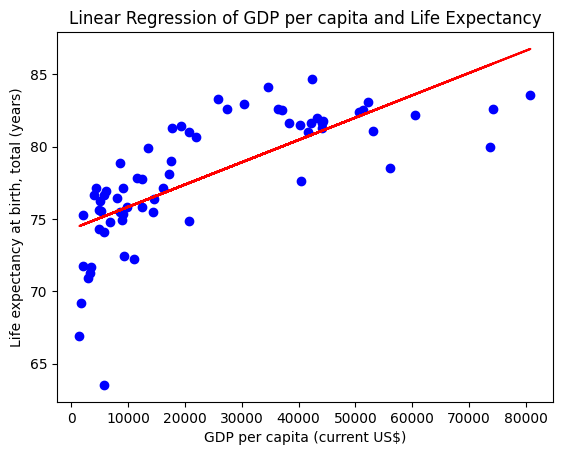

In [7]:
from e2b_code_interpreter import CodeInterpreter

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat(
    code_interpreter,
    "Make a chart showing linear regression of the relationship between GDP per capita and life expectancy from the global_economy_indicators. Filter out any missing values or values in wrong format."
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code interpreter results")


# This will render the image
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result